In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
sns.set(style="whitegrid", context="talk")

# Nạp dữ liệu và hợp nhất các file CSV
data_dir = "/Users/hangvu/Documents/school/S2_24-25/AI/Processed_CSV"  # Thư mục chứa file CSV
csv_files = glob.glob(os.path.join(data_dir, "AWS_*.csv"))

# Đọc từng file CSV và hợp nhất vào một DataFrame
df_list = []
for file in csv_files:
    temp_df = pd.read_csv(file, parse_dates=['datetime'])
    df_list.append(temp_df)
    
df = pd.concat(df_list, ignore_index=True)
print("Kích thước dữ liệu:", df.shape)

Kích thước dữ liệu: (63157500, 4)


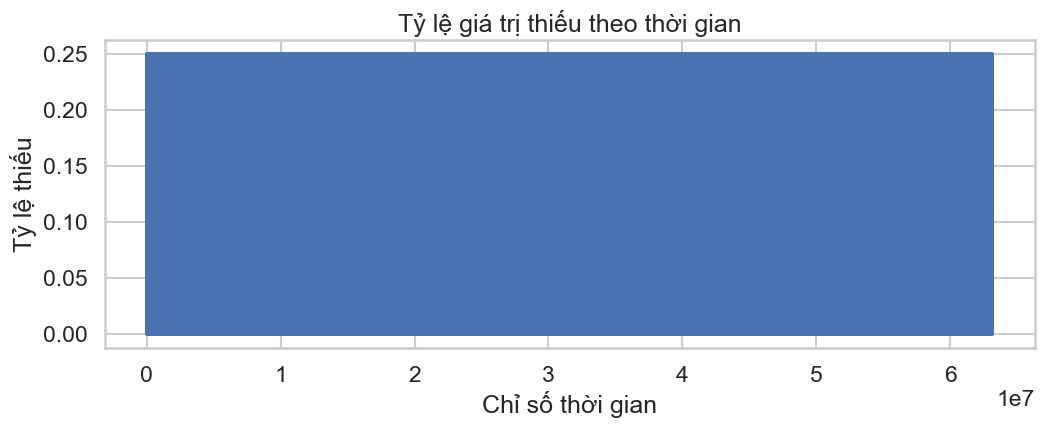

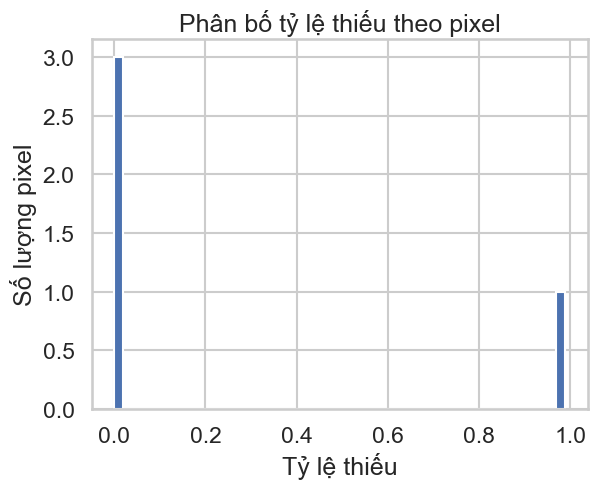

In [ ]:
# Thay thế giá trị đặc biệt thành NaN
df.replace([-9999, -np.inf, np.nan], np.nan, inplace=True)

Số pixel có trạm đo: 334
Tỷ lệ phủ trạm: 1.48%


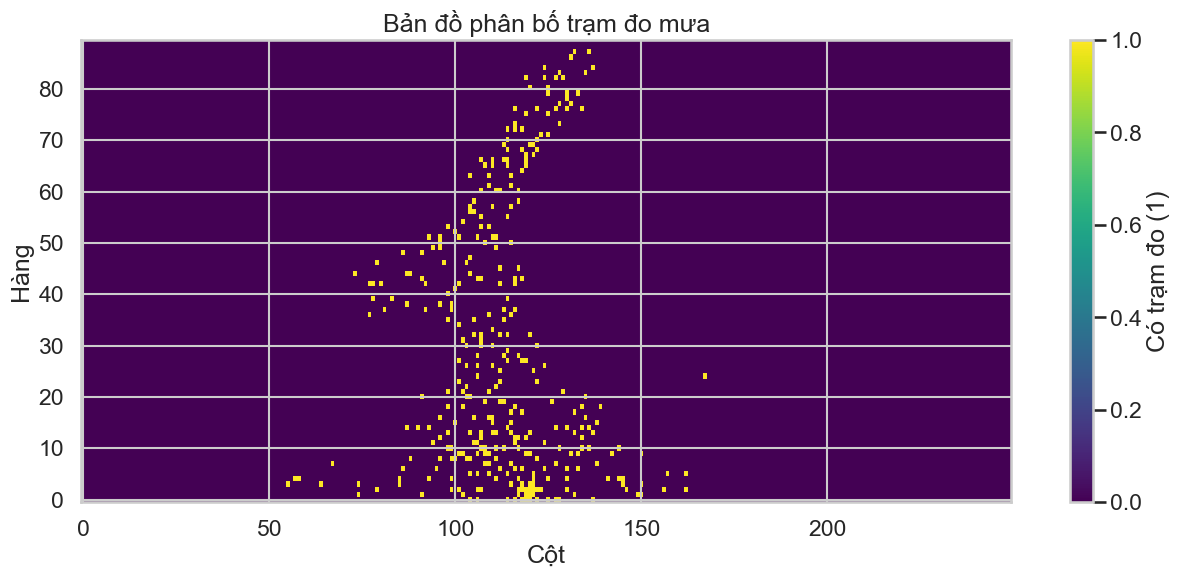

In [4]:
valid_df = df[df['value'] >= 0].copy()

# Tạo mask toàn bộ khu vực (90x250)
full_grid = pd.DataFrame([(row, col) for row in range(90) for col in range(250)], 
                        columns=['row', 'col'])

# Đếm số pixel có ít nhất 1 bản ghi valid
valid_pixels = valid_df.groupby(['row', 'col']).size().reset_index(name='count')
merged_grid = full_grid.merge(valid_pixels, how='left', on=['row', 'col'])
merged_grid['has_station'] = merged_grid['count'].notna()

print(f"Số pixel có trạm đo: {merged_grid['has_station'].sum()}")
print(f"Tỷ lệ phủ trạm: {merged_grid['has_station'].mean():.2%}")

# Visualize phân bố trạm
plt.figure(figsize=(15,6))
plt.imshow(merged_grid['has_station'].values.reshape(90,250), 
          cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='Có trạm đo (1)')
plt.title('Bản đồ phân bố trạm đo mưa')
plt.xlabel('Cột')
plt.ylabel('Hàng')
plt.show()

-> Nên loại bỏ các điểm không có dữ liệu thay vì nội suy

In [ ]:
print("\nThống kê mô tả của 'value':")
print(df['value'].describe())

# Tính tỷ lệ giá trị missing trong cột 'value'
total_records = df.shape[0]
missing_count = df['value'].isna().sum()
print(f"\nSố lượng giá trị missing trong 'value': {missing_count} ({(missing_count/total_records)*100:.2f}%)")


Thống kê mô tả của 'value':
count    657681.000000
mean          0.363923
std           2.258714
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         121.599998
Name: value, dtype: float64

Số lượng giá trị missing trong 'value': 62499819 (98.96%)


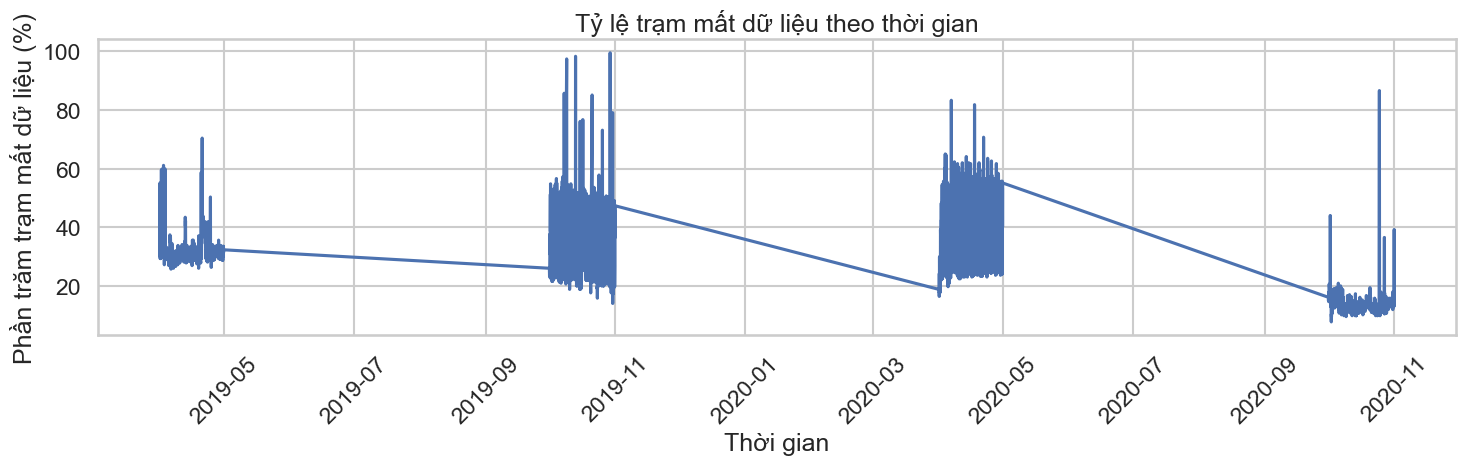

Số thời điểm có trên 50% trạm mất dữ liệu: 345

Thời điểm mất dữ liệu đồng loạt (>50% trạm):
- Từ 2019-04-01 01:00:00 đến 2019-04-01 01:00:00: 0.0 giờ, trung bình 55.1% trạm mất dữ liệu
- Từ 2019-04-01 17:00:00 đến 2019-04-01 17:00:00: 0.0 giờ, trung bình 59.6% trạm mất dữ liệu
- Từ 2019-04-02 03:00:00 đến 2019-04-02 03:00:00: 0.0 giờ, trung bình 59.9% trạm mất dữ liệu
- Từ 2019-04-02 17:00:00 đến 2019-04-02 17:00:00: 0.0 giờ, trung bình 61.1% trạm mất dữ liệu
- Từ 2019-04-03 05:00:00 đến 2019-04-03 05:00:00: 0.0 giờ, trung bình 55.7% trạm mất dữ liệu
- Từ 2019-04-03 10:00:00 đến 2019-04-03 10:00:00: 0.0 giờ, trung bình 59.9% trạm mất dữ liệu
- Từ 2019-04-03 11:00:00 đến 2019-04-03 11:00:00: 0.0 giờ, trung bình 56.9% trạm mất dữ liệu
- Từ 2019-04-03 12:00:00 đến 2019-04-03 12:00:00: 0.0 giờ, trung bình 56.3% trạm mất dữ liệu
- Từ 2019-04-20 10:00:00 đến 2019-04-20 10:00:00: 0.0 giờ, trung bình 58.7% trạm mất dữ liệu
- Từ 2019-04-20 20:00:00 đến 2019-04-20 20:00:00: 0.0 giờ, trung bình 

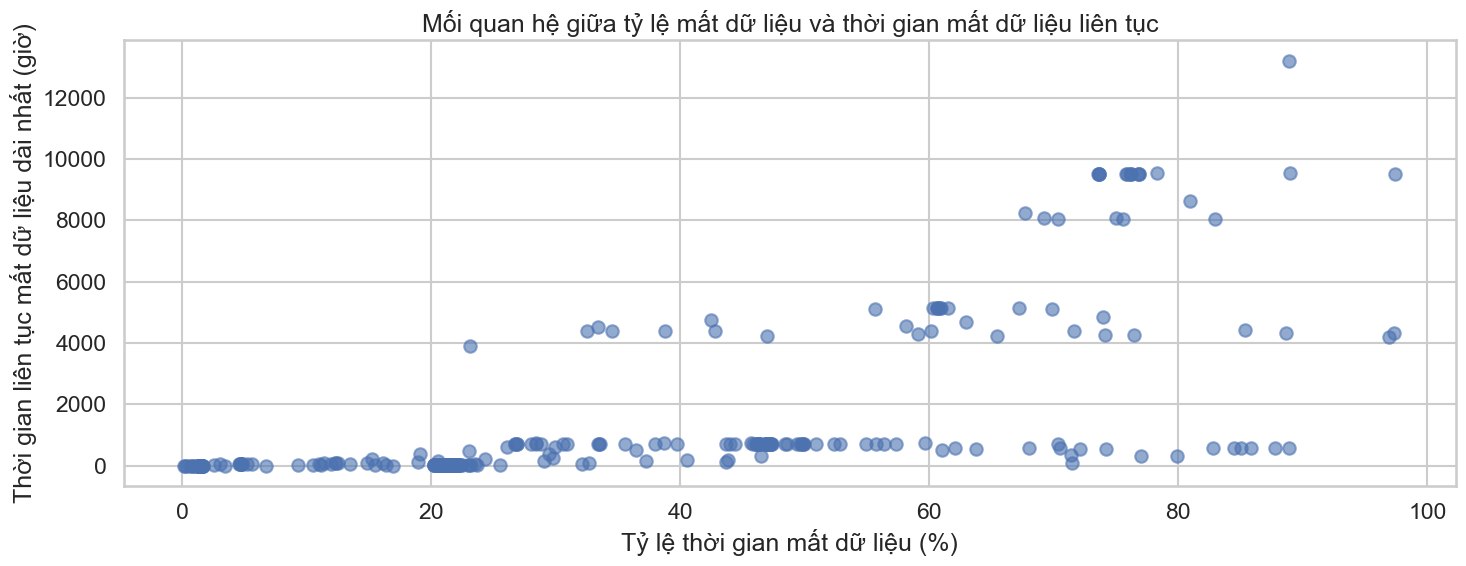


Số trạm có thời gian mất dữ liệu liên tục > 24 giờ: 175
Chiếm 52.4% tổng số trạm

Thống kê trạm có thời gian mất dữ liệu dài:
       longest_gap_hours  missing_percentage
count         175.000000          175.000000
mean         2367.022857           48.093236
std          3146.727075           23.983668
min            27.000000            3.063769
25%           381.000000           29.640185
50%           719.000000           46.989669
75%          4383.000000           69.522622
max         13206.000000           97.434984


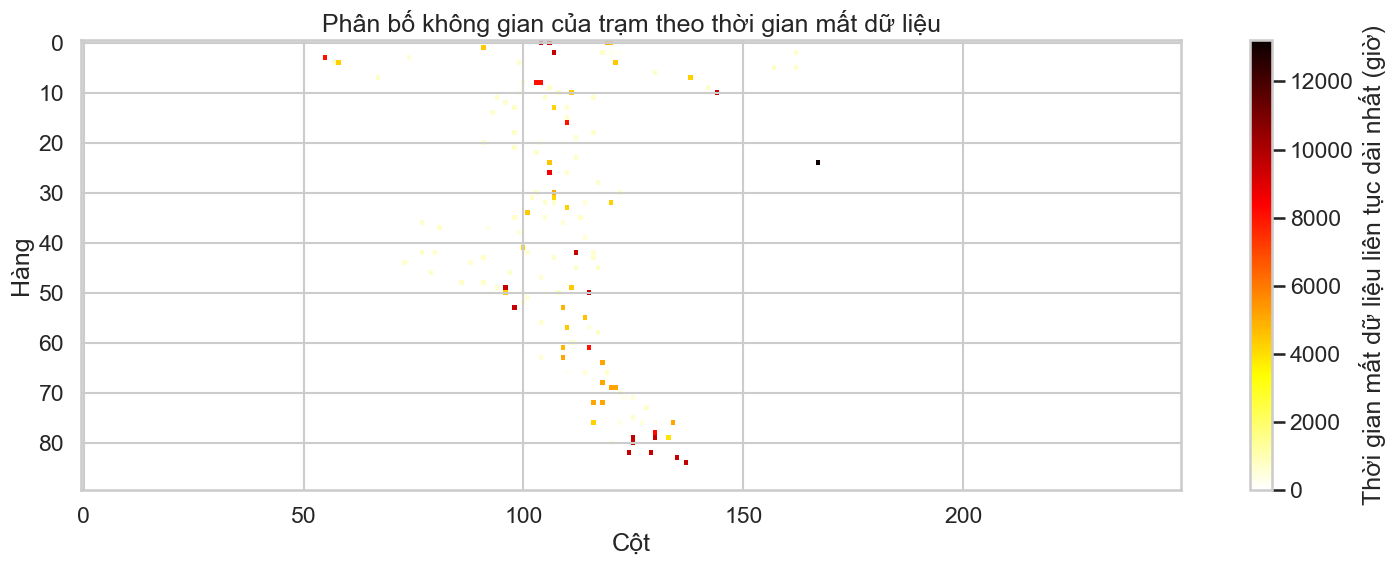

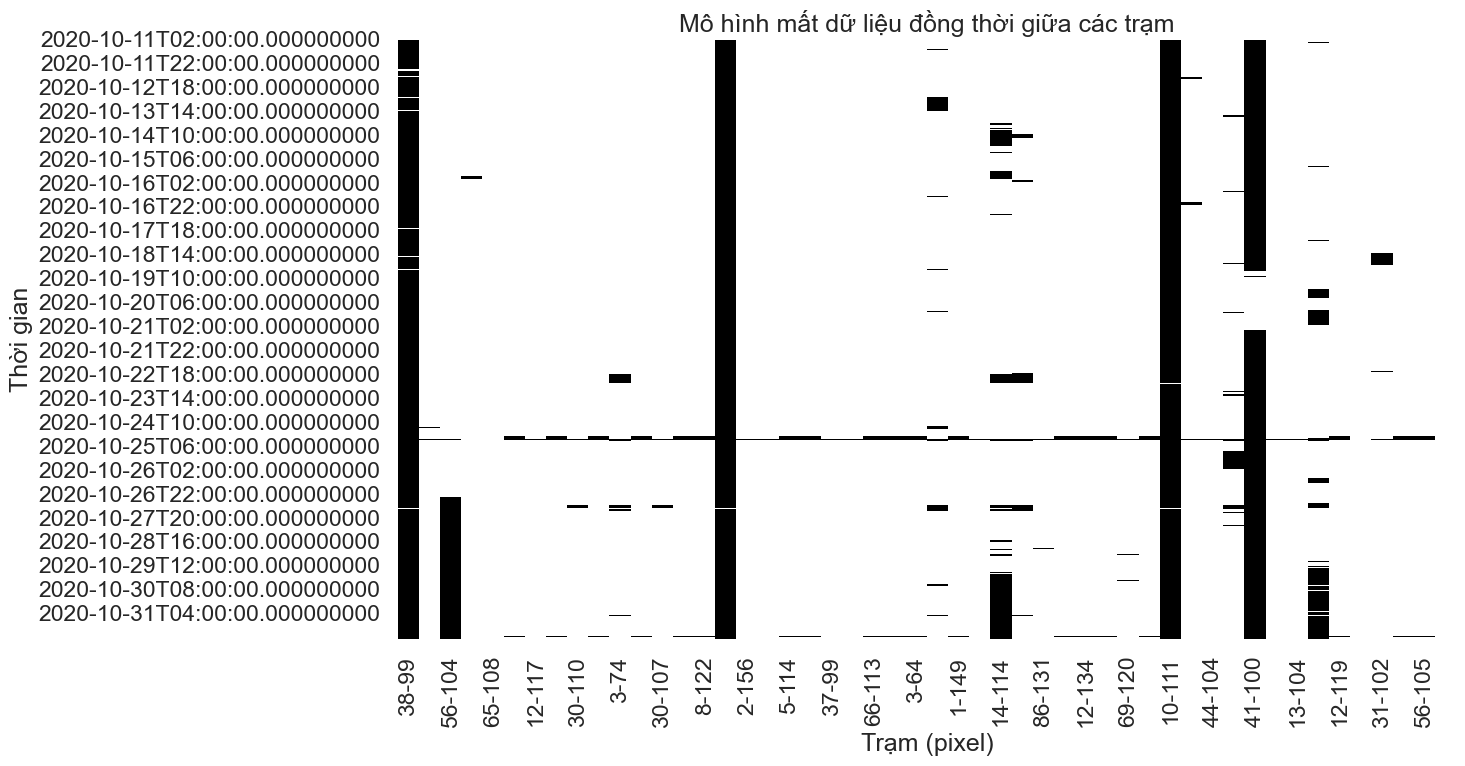

In [7]:
# Analyzing simultaneous missing data patterns across pixels
import matplotlib.dates as mdates

# Convert the DataFrame index to datetime if not already
pivot_df.index = pd.to_datetime(pivot_df.index)

# 1. Calculate the percentage of stations missing data at each timestamp
missing_by_time = pivot_df.isna().mean(axis=1) * 100

# Plot the percentage of stations with missing data over time
plt.figure(figsize=(15, 5))
plt.plot(missing_by_time.index, missing_by_time.values)
plt.title('Tỷ lệ trạm mất dữ liệu theo thời gian')
plt.ylabel('Phần trăm trạm mất dữ liệu (%)')
plt.xlabel('Thời gian')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Find periods with high missing data rates (>50% stations missing)
high_missing_periods = missing_by_time[missing_by_time > 50]
print(f"Số thời điểm có trên 50% trạm mất dữ liệu: {len(high_missing_periods)}")

if len(high_missing_periods) > 0:
    # Group consecutive timestamps to find continuous periods
    from itertools import groupby
    from operator import itemgetter
    
    # Convert to list of (datetime, value) pairs
    high_missing_pairs = list(zip(high_missing_periods.index, high_missing_periods.values))
    
    # Find continuous periods
    result = []
    for k, g in groupby(enumerate(high_missing_pairs), lambda x: x[0] - x[1][0].to_pydatetime().timestamp()):
        group = list(map(itemgetter(1), g))
        start_time = group[0][0]
        end_time = group[-1][0]
        avg_missing = sum(v for _, v in group) / len(group)
        duration_hours = (end_time - start_time).total_seconds() / 3600
        result.append((start_time, end_time, duration_hours, avg_missing))
    
    # Display periods of widespread outages
    if result:
        print("\nThời điểm mất dữ liệu đồng loạt (>50% trạm):")
        for start, end, duration, avg in sorted(result, key=lambda x: x[2], reverse=True):
            print(f"- Từ {start} đến {end}: {duration:.1f} giờ, trung bình {avg:.1f}% trạm mất dữ liệu")

# 3. Find pixels with long continuous missing periods
# Calculate longest continuous missing period for each station
longest_missing_period = {}
missing_time_percentage = {}

for station in pivot_df.columns:
    # Get missing data mask
    is_missing = pivot_df[station].isna()
    
    # Calculate percentage of missing data
    missing_percentage = is_missing.mean() * 100
    missing_time_percentage[station] = missing_percentage
    
    # Find runs of True values (missing data)
    runs = []
    run_start = None
    
    for i, missing in enumerate(is_missing):
        if missing and run_start is None:
            run_start = i
        elif not missing and run_start is not None:
            runs.append((run_start, i-1))
            run_start = None
    
    # Don't forget the last run
    if run_start is not None:
        runs.append((run_start, len(is_missing)-1))
    
    # Calculate longest period in hours
    if runs:
        longest_run = max(runs, key=lambda x: x[1]-x[0])
        start_time = pivot_df.index[longest_run[0]]
        end_time = pivot_df.index[longest_run[1]]
        duration_hours = (end_time - start_time).total_seconds() / 3600
        longest_missing_period[station] = duration_hours

# Convert to DataFrames for analysis
missing_periods_df = pd.DataFrame({
    'station': list(longest_missing_period.keys()),
    'longest_gap_hours': list(longest_missing_period.values()),
    'missing_percentage': [missing_time_percentage[s] for s in longest_missing_period.keys()]
})

# Add row and col as separate columns
missing_periods_df[['row', 'col']] = pd.DataFrame(
    [tuple(map(int, station)) for station in missing_periods_df['station']], 
    index=missing_periods_df.index
)

# 4. Visualize stations with long missing periods
plt.figure(figsize=(15, 6))
plt.scatter(missing_periods_df['missing_percentage'], 
           missing_periods_df['longest_gap_hours'], 
           alpha=0.6)
plt.xlabel('Tỷ lệ thời gian mất dữ liệu (%)')
plt.ylabel('Thời gian liên tục mất dữ liệu dài nhất (giờ)')
plt.title('Mối quan hệ giữa tỷ lệ mất dữ liệu và thời gian mất dữ liệu liên tục')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Categorize stations by missing data severity
severe_missing = missing_periods_df[missing_periods_df['longest_gap_hours'] > 24]
print(f"\nSố trạm có thời gian mất dữ liệu liên tục > 24 giờ: {len(severe_missing)}")
print(f"Chiếm {len(severe_missing)/len(missing_periods_df):.1%} tổng số trạm")

# Print statistics of severe stations
if not severe_missing.empty:
    print("\nThống kê trạm có thời gian mất dữ liệu dài:")
    print(severe_missing[['longest_gap_hours', 'missing_percentage']].describe())

# 6. Visualize spatial distribution of missing data severity
missing_map = np.zeros((90, 250))
for _, row in missing_periods_df.iterrows():
    missing_map[int(row['row']), int(row['col'])] = row['longest_gap_hours']

plt.figure(figsize=(15, 6))
plt.imshow(missing_map, cmap='hot_r', aspect='auto')
plt.colorbar(label='Thời gian mất dữ liệu liên tục dài nhất (giờ)')
plt.title('Phân bố không gian của trạm theo thời gian mất dữ liệu')
plt.xlabel('Cột')
plt.ylabel('Hàng')
plt.tight_layout()
plt.show()

# 7. Create heatmap showing simultaneous missing data
# Sample a time period and 50 random stations to visualize (if too large)
sample_period = pivot_df.iloc[-500:] if len(pivot_df) > 500 else pivot_df
sample_stations = np.random.choice(sample_period.columns, 
                                  min(50, len(sample_period.columns)), 
                                  replace=False)
missing_sample = sample_period[sample_stations].isna()

plt.figure(figsize=(15, 8))
sns.heatmap(missing_sample, cmap='binary', cbar=False, 
           yticklabels=20, xticklabels=2)
plt.title('Mô hình mất dữ liệu đồng thời giữa các trạm')
plt.xlabel('Trạm (pixel)')
plt.ylabel('Thời gian')
plt.tight_layout()
plt.show()

Số lượng pixel có trạm đo: 334


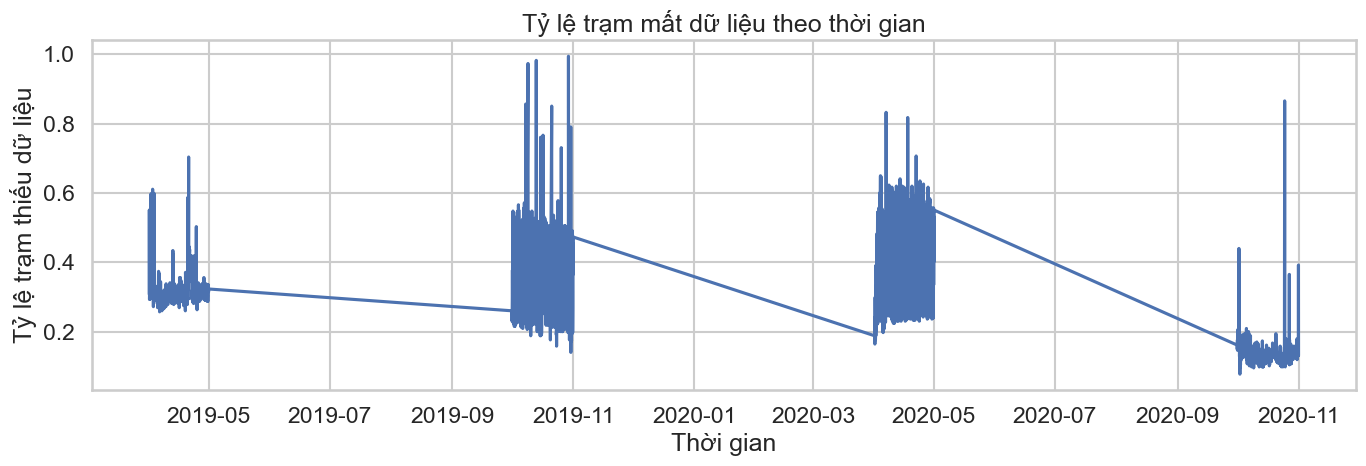

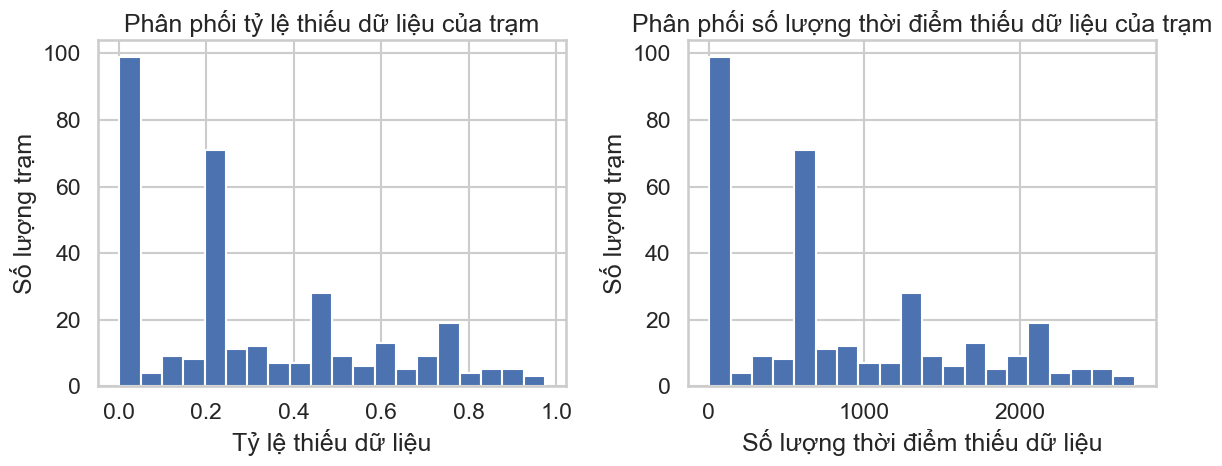

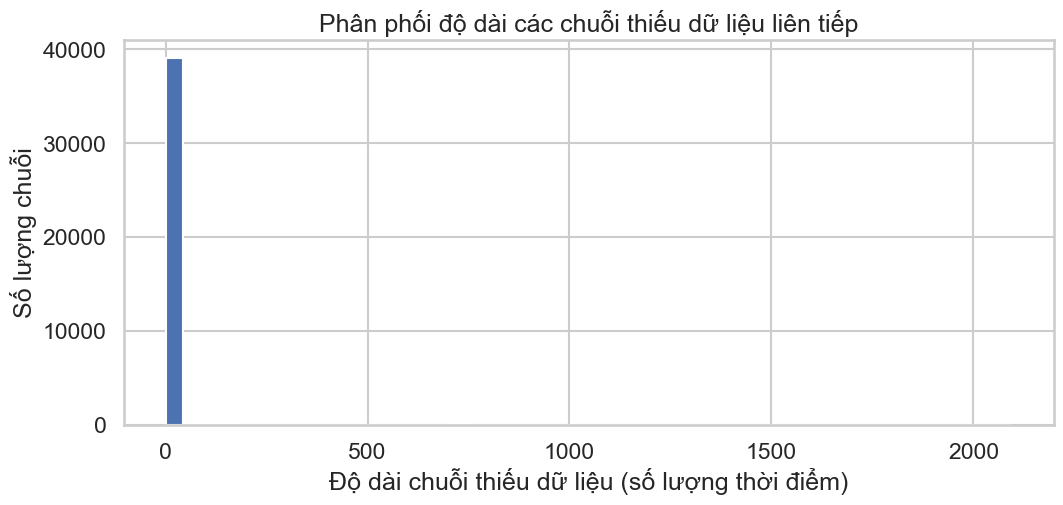

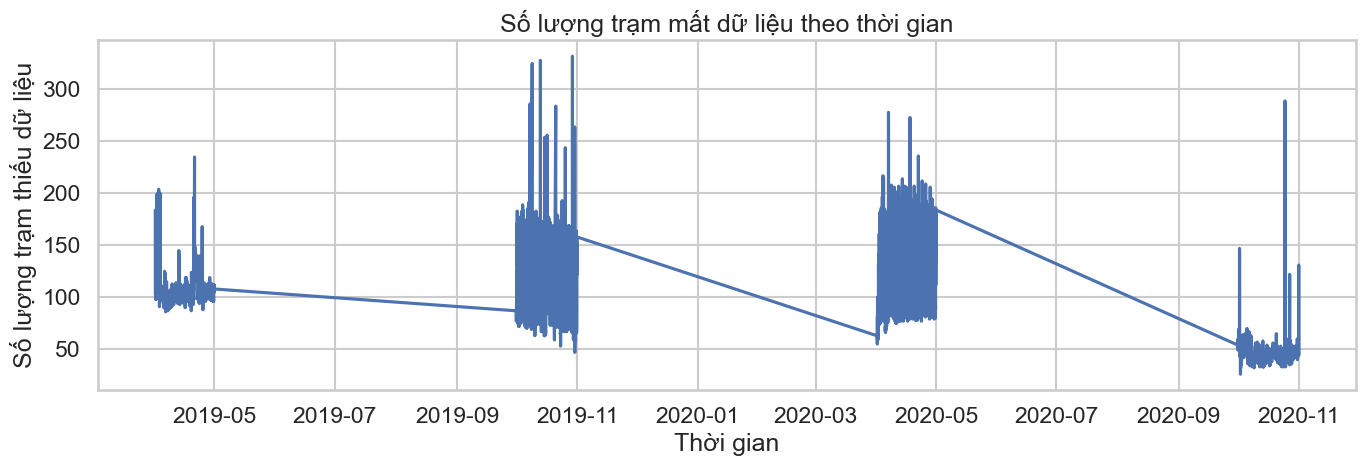

10 thời điểm có nhiều trạm mất dữ liệu nhất:
2019-10-29 13:00:00: 332 trạm (99.40% tổng số trạm)
2019-10-13 07:00:00: 328 trạm (98.20% tổng số trạm)
2019-10-09 03:00:00: 325 trạm (97.31% tổng số trạm)
2020-10-24 23:00:00: 289 trạm (86.53% tổng số trạm)
2019-10-07 23:00:00: 286 trạm (85.63% tổng số trạm)
2019-10-21 02:00:00: 284 trạm (85.03% tổng số trạm)
2020-04-06 20:00:00: 278 trạm (83.23% tổng số trạm)
2020-04-17 18:00:00: 273 trạm (81.74% tổng số trạm)
2019-10-30 17:00:00: 264 trạm (79.04% tổng số trạm)
2019-10-16 17:00:00: 256 trạm (76.65% tổng số trạm)
Có quá nhiều trạm để hiển thị ma trận tương quan đầy đủ


In [8]:
# Phân tích mẫu thiếu dữ liệu trong các pixel có trạm đo

# 1. Lấy danh sách các pixel có trạm đo
pixels_with_stations = merged_grid[merged_grid['has_station']]['row'].astype(str) + '_' + merged_grid[merged_grid['has_station']]['col'].astype(str)
stations_list = list(pixels_with_stations)
print(f"Số lượng pixel có trạm đo: {len(stations_list)}")

# 2. Tạo DataFrame chứa thông tin thiếu dữ liệu cho mỗi trạm theo thời gian
# Tạo một cột định danh cho mỗi pixel
df['pixel_id'] = df['row'].astype(str) + '_' + df['col'].astype(str)

# Giữ lại chỉ các pixel có trạm đo
stations_df = df[df['pixel_id'].isin(stations_list)].copy()

# Tạo bảng pivot để phân tích sự thiếu dữ liệu theo thời gian
pivot_df = stations_df.pivot(index='datetime', columns='pixel_id', values='value')

# 3. Phân tích mẫu thiếu dữ liệu
# Tỷ lệ thiếu dữ liệu cho mỗi thời điểm
missing_by_time = pivot_df.isnull().mean(axis=1)

# Tỷ lệ thiếu dữ liệu cho mỗi trạm
missing_by_station = pivot_df.isnull().mean(axis=0)

# Số lượng thời điểm mỗi trạm bị mất dữ liệu
missing_count_by_station = pivot_df.isnull().sum(axis=0)

# 4. Visualize kết quả
plt.figure(figsize=(14, 5))
plt.plot(missing_by_time.index, missing_by_time.values)
plt.title('Tỷ lệ trạm mất dữ liệu theo thời gian')
plt.ylabel('Tỷ lệ trạm thiếu dữ liệu')
plt.xlabel('Thời gian')
plt.grid(True)
plt.tight_layout()
plt.show()

# Phân phối tỷ lệ thiếu dữ liệu của các trạm
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(missing_by_station, bins=20)
plt.title('Phân phối tỷ lệ thiếu dữ liệu của trạm')
plt.xlabel('Tỷ lệ thiếu dữ liệu')
plt.ylabel('Số lượng trạm')

plt.subplot(1, 2, 2)
plt.hist(missing_count_by_station, bins=20)
plt.title('Phân phối số lượng thời điểm thiếu dữ liệu của trạm')
plt.xlabel('Số lượng thời điểm thiếu dữ liệu')
plt.ylabel('Số lượng trạm')
plt.tight_layout()
plt.show()

# 5. Phân tích cụm mất dữ liệu
# Xác định các chuỗi thiếu dữ liệu liên tiếp
def find_consecutive_missing(series):
    """Tìm các chuỗi giá trị NaN liên tiếp trong series"""
    mask = series.isnull()
    if not mask.any():
        return []
    
    # Sử dụng diff để tìm điểm bắt đầu và kết thúc của chuỗi NaN
    idx = np.flatnonzero(mask.astype(int).diff().fillna(0))
    if mask.iloc[0]:
        idx = np.r_[0, idx]
    if mask.iloc[-1]:
        idx = np.r_[idx, len(mask)]
    
    # Ghép cặp các điểm bắt đầu và kết thúc
    result = []
    for i in range(0, len(idx), 2):
        if i+1 < len(idx):
            start, end = idx[i], idx[i+1]
            length = end - start
            result.append((start, end, length))
    
    return result

# Tính toán thống kê về các chuỗi mất dữ liệu liên tiếp
gap_stats = []
for station in pivot_df.columns:
    station_series = pivot_df[station]
    gaps = find_consecutive_missing(station_series)
    
    for start, end, length in gaps:
        gap_stats.append({
            'station': station,
            'start_idx': start,
            'end_idx': end,
            'length': length,
            'start_time': station_series.index[start],
            'end_time': station_series.index[end-1] if end > 0 else None
        })

gap_df = pd.DataFrame(gap_stats)

# Thống kê độ dài của các khoảng thiếu dữ liệu
plt.figure(figsize=(12, 5))
plt.hist(gap_df['length'], bins=50)
plt.title('Phân phối độ dài các chuỗi thiếu dữ liệu liên tiếp')
plt.xlabel('Độ dài chuỗi thiếu dữ liệu (số lượng thời điểm)')
plt.ylabel('Số lượng chuỗi')
plt.grid(True)
plt.show()

# 6. Phân tích thời điểm mất dữ liệu đồng thời (có bao nhiêu trạm cùng mất dữ liệu)
missing_count_over_time = pivot_df.isnull().sum(axis=1)
plt.figure(figsize=(14, 5))
plt.plot(missing_count_over_time.index, missing_count_over_time.values)
plt.title('Số lượng trạm mất dữ liệu theo thời gian')
plt.ylabel('Số lượng trạm thiếu dữ liệu')
plt.xlabel('Thời gian')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Tìm thời điểm có nhiều trạm cùng mất dữ liệu nhất
worst_times = missing_count_over_time.nlargest(10)
print("10 thời điểm có nhiều trạm mất dữ liệu nhất:")
for time, count in worst_times.items():
    print(f"{time}: {count} trạm ({count/len(stations_list):.2%} tổng số trạm)")

# 8. Tính toán ma trận tương quan thiếu dữ liệu giữa các trạm
# Giới hạn số trạm để phân tích (để tránh ma trận quá lớn)
if len(stations_list) <= 100:
    missing_corr = pivot_df.isnull().corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(missing_corr, cmap='coolwarm', center=0)
    plt.title('Tương quan thiếu dữ liệu giữa các trạm')
    plt.tight_layout()
    plt.show()
else:
    print("Có quá nhiều trạm để hiển thị ma trận tương quan đầy đủ")

Số lượng trạm có tỷ lệ mất dữ liệu > 80%: 15
Chiếm 4.49% tổng số trạm đo

Danh sách trạm có tỷ lệ mất dữ liệu > 80%:
pixel_id
49_96     0.974350
4_58      0.973281
13_107    0.969362
10_144    0.889562
24_167    0.889206
63_104    0.889206
10_111    0.886712
35_105    0.877449
66_114    0.858568
34_101    0.853580
42_101    0.850730
42_116    0.844674
8_103     0.829711
38_99     0.827574
26_106    0.809405
dtype: float64


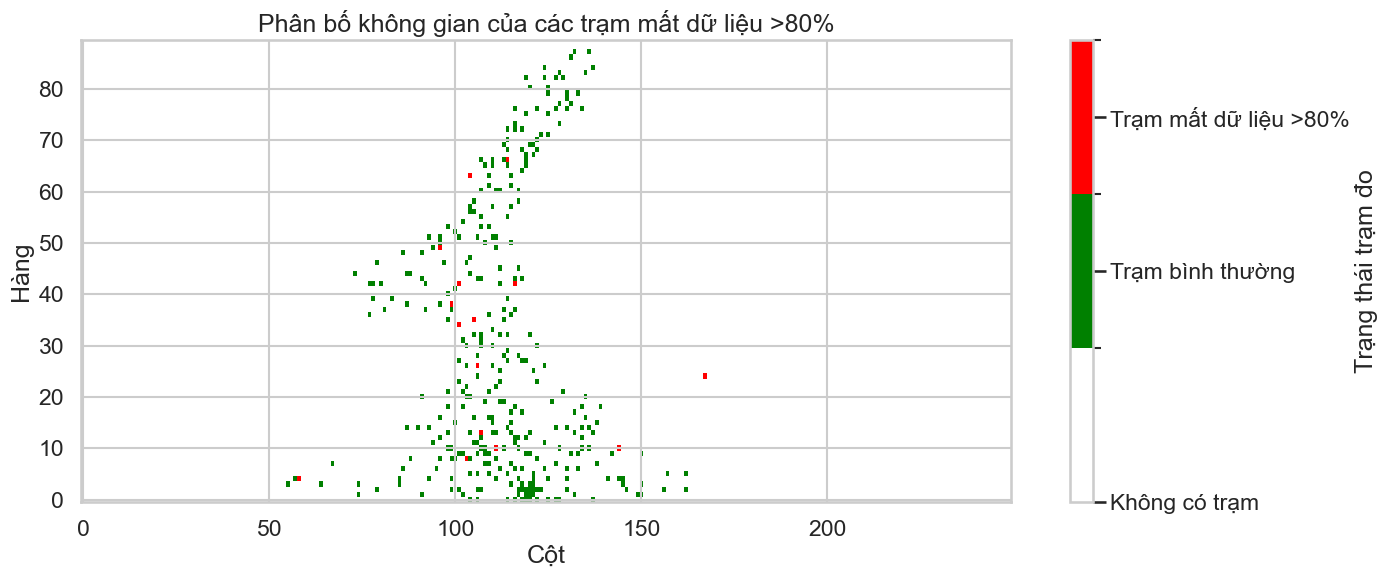


Phân tích trạm 10_111 (mất 88.67% dữ liệu):
Số lượng thời điểm có dữ liệu: 318
Khoảng cách trung bình giữa các thời điểm có dữ liệu: 43.56 giờ
Khoảng cách lớn nhất giữa các thời điểm có dữ liệu: 4338.00 giờ


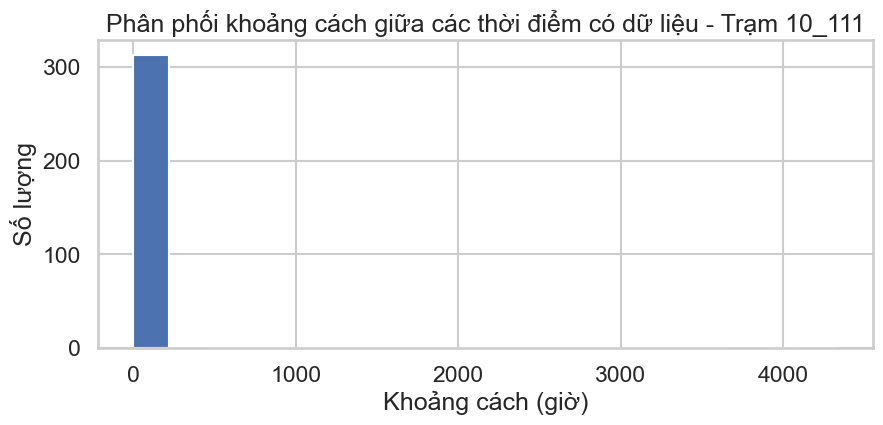

/var/folders/sd/s31k2k696jlcwgcfc6t8y0n00000gn/T/ipykernel_4165/1909925499.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_missing = high_missing_df.groupby('month').apply(


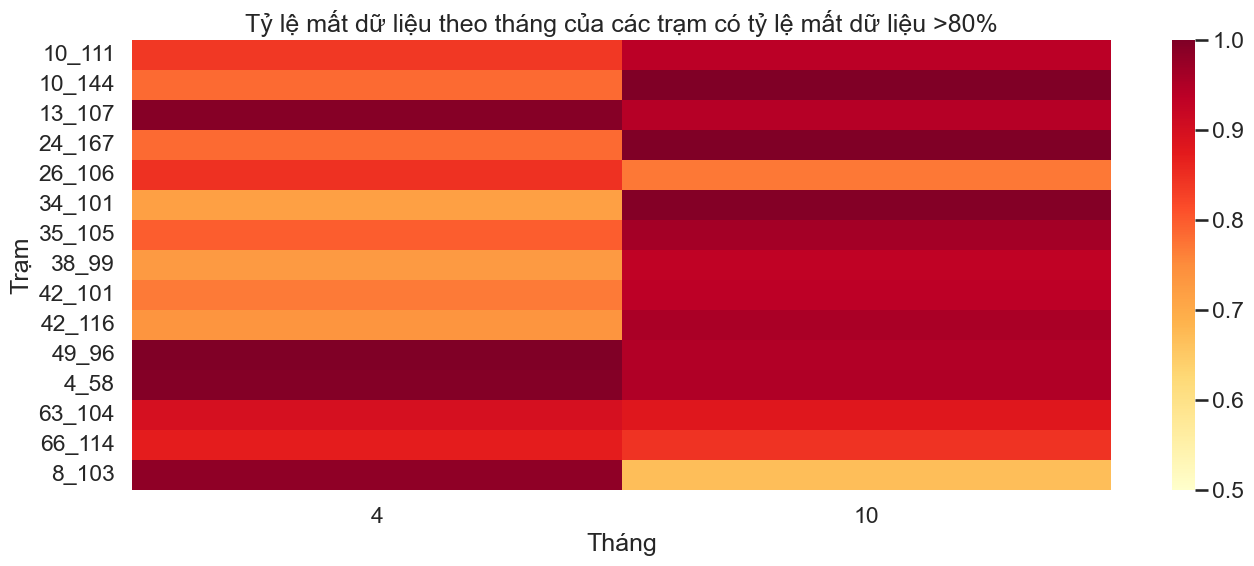


Thời gian thu thập dữ liệu: từ 2019-04-01 đến 2020-10-31 (579 ngày)

Trạm 10_111:
  - Thời gian hoạt động: từ 2019-04-01 đến 2020-10-27 (575 ngày)
  - Tỷ lệ thời gian hoạt động so với tổng thời gian: 99.31%
  - Số ngày có dữ liệu: 54
  - Tỷ lệ ngày có dữ liệu trong khoảng hoạt động: 9.39%

Trạm 10_144:
  - Thời gian hoạt động: từ 2019-04-01 đến 2019-04-30 (29 ngày)
  - Tỷ lệ thời gian hoạt động so với tổng thời gian: 5.01%
  - Số ngày có dữ liệu: 23
  - Tỷ lệ ngày có dữ liệu trong khoảng hoạt động: 79.31%

Trạm 13_107:
  - Thời gian hoạt động: từ 2019-04-02 đến 2020-10-27 (574 ngày)
  - Tỷ lệ thời gian hoạt động so với tổng thời gian: 99.14%
  - Số ngày có dữ liệu: 30
  - Tỷ lệ ngày có dữ liệu trong khoảng hoạt động: 5.23%

Trạm 24_167:
  - Thời gian hoạt động: từ 2019-04-01 đến 2019-04-30 (29 ngày)
  - Tỷ lệ thời gian hoạt động so với tổng thời gian: 5.01%
  - Số ngày có dữ liệu: 23
  - Tỷ lệ ngày có dữ liệu trong khoảng hoạt động: 79.31%

Trạm 26_106:
  - Thời gian hoạt động: từ 201

In [15]:
# Tìm các pixel có trạm đo mà thời gian mất dữ liệu lớn hơn 80%
from matplotlib import colors  # Import module colors

# Sử dụng missing_by_station đã tính ở phần trước
high_missing_stations = missing_by_station[missing_by_station > 0.8]

print(f"Số lượng trạm có tỷ lệ mất dữ liệu > 80%: {len(high_missing_stations)}")
print(f"Chiếm {len(high_missing_stations)/len(stations_list):.2%} tổng số trạm đo")

if len(high_missing_stations) > 0:
    print("\nDanh sách trạm có tỷ lệ mất dữ liệu > 80%:")
    print(high_missing_stations.sort_values(ascending=False))
    
    # Phân tích phân bố không gian của các trạm mất dữ liệu nhiều
    high_missing_ids = high_missing_stations.index
    
    # Tách row và col từ pixel_id
    high_missing_locations = pd.DataFrame([
        {'pixel_id': pid, 'row': int(pid.split('_')[0]), 'col': int(pid.split('_')[1])} 
        for pid in high_missing_ids
    ])
    
    # Tạo bản đồ phân bố các trạm mất dữ liệu nhiều
    # Tạo một mảng 2D để lưu trữ trạng thái của các pixel
    missing_map = np.zeros((90, 250))
    
    # Đánh dấu các pixel có trạm đo (giá trị 1)
    for _, row in merged_grid[merged_grid['has_station']].iterrows():
        missing_map[row['row'], row['col']] = 1
    
    # Đánh dấu các pixel có trạm đo nhưng mất dữ liệu > 80% (giá trị 2)
    for _, row in high_missing_locations.iterrows():
        missing_map[row['row'], row['col']] = 2
    
    # Vẽ bản đồ
    plt.figure(figsize=(15, 6))
    cmap = colors.ListedColormap(['white', 'green', 'red'])
    bounds = [0, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    img = plt.imshow(missing_map, cmap=cmap, norm=norm, aspect='auto', origin='lower')
    cbar = plt.colorbar(img, ticks=[0, 1, 2], label='Trạng thái trạm đo')
    cbar.set_ticklabels(['Không có trạm', 'Trạm bình thường', 'Trạm mất dữ liệu >80%'])
    
    plt.title('Phân bố không gian của các trạm mất dữ liệu >80%')
    plt.xlabel('Cột')
    plt.ylabel('Hàng')
    plt.show()
    
    # Phân tích mẫu dữ liệu còn lại của các trạm này
    if len(high_missing_stations) > 0:
        # Lấy một mẫu trạm có tỷ lệ mất dữ liệu cao để phân tích
        sample_high_missing = high_missing_stations.index[0]
        
        # Tìm các thời điểm có dữ liệu
        valid_times = pivot_df[sample_high_missing].dropna().index
        
        if len(valid_times) > 0:
            print(f"\nPhân tích trạm {sample_high_missing} (mất {high_missing_stations[sample_high_missing]:.2%} dữ liệu):")
            print(f"Số lượng thời điểm có dữ liệu: {len(valid_times)}")
            
            # Khoảng cách giữa các thời điểm có dữ liệu
            if len(valid_times) > 1:
                time_diffs = [(valid_times[i+1] - valid_times[i]).total_seconds()/3600 
                             for i in range(len(valid_times)-1)]
                
                print(f"Khoảng cách trung bình giữa các thời điểm có dữ liệu: {np.mean(time_diffs):.2f} giờ")
                print(f"Khoảng cách lớn nhất giữa các thời điểm có dữ liệu: {np.max(time_diffs):.2f} giờ")
                
                plt.figure(figsize=(10, 4))
                plt.hist(time_diffs, bins=20)
                plt.title(f'Phân phối khoảng cách giữa các thời điểm có dữ liệu - Trạm {sample_high_missing}')
                plt.xlabel('Khoảng cách (giờ)')
                plt.ylabel('Số lượng')
                plt.grid(True)
                plt.show()

# Tính toán tỷ lệ ngày/tháng có dữ liệu cho các trạm mất dữ liệu nhiều
if len(high_missing_stations) > 0:
    # Tạo DataFrame chỉ chứa các trạm có tỷ lệ mất dữ liệu cao
    high_missing_df = pivot_df[high_missing_stations.index].copy()
    
    # Thêm cột ngày và tháng
    high_missing_df['day'] = high_missing_df.index.day
    high_missing_df['month'] = high_missing_df.index.month
    high_missing_df['year'] = high_missing_df.index.year
    
    # Tính tỷ lệ mất dữ liệu theo tháng
    monthly_missing = high_missing_df.groupby('month').apply(
        lambda x: x[high_missing_stations.index].isnull().mean()
    )
    
    # Vẽ biểu đồ tỷ lệ mất dữ liệu theo tháng
    plt.figure(figsize=(14, 6))
    sns.heatmap(monthly_missing.T, cmap='YlOrRd', vmin=0.5, vmax=1.0)
    plt.title('Tỷ lệ mất dữ liệu theo tháng của các trạm có tỷ lệ mất dữ liệu >80%')
    plt.ylabel('Trạm')
    plt.xlabel('Tháng')
    plt.tight_layout()
    plt.show()
    
    # Thống kê thêm về thời gian thu thập dữ liệu
    first_date = pivot_df.index.min()
    last_date = pivot_df.index.max()
    total_days = (last_date - first_date).days
    
    print(f"\nThời gian thu thập dữ liệu: từ {first_date.date()} đến {last_date.date()} ({total_days} ngày)")
    
    # Kiểm tra xem có trạm nào có dữ liệu tập trung trong một giai đoạn cụ thể không
    for station in high_missing_stations.index[:min(5, len(high_missing_stations))]:
        valid_times = pivot_df[station].dropna().index
        if len(valid_times) > 0:
            station_first = valid_times.min()
            station_last = valid_times.max()
            active_days = (station_last - station_first).days
            
            # Tạo một tập hợp các ngày duy nhất
            unique_dates = set([d.date() for d in valid_times])
            
            print(f"\nTrạm {station}:")
            print(f"  - Thời gian hoạt động: từ {station_first.date()} đến {station_last.date()} ({active_days} ngày)")
            print(f"  - Tỷ lệ thời gian hoạt động so với tổng thời gian: {active_days/total_days:.2%}")
            print(f"  - Số ngày có dữ liệu: {len(unique_dates)}")
            if active_days > 0:
                print(f"  - Tỷ lệ ngày có dữ liệu trong khoảng hoạt động: {len(unique_dates)/active_days:.2%}")
            else:
                print("  - Tỷ lệ ngày có dữ liệu trong khoảng hoạt động: N/A (hoạt động trong cùng ngày)")

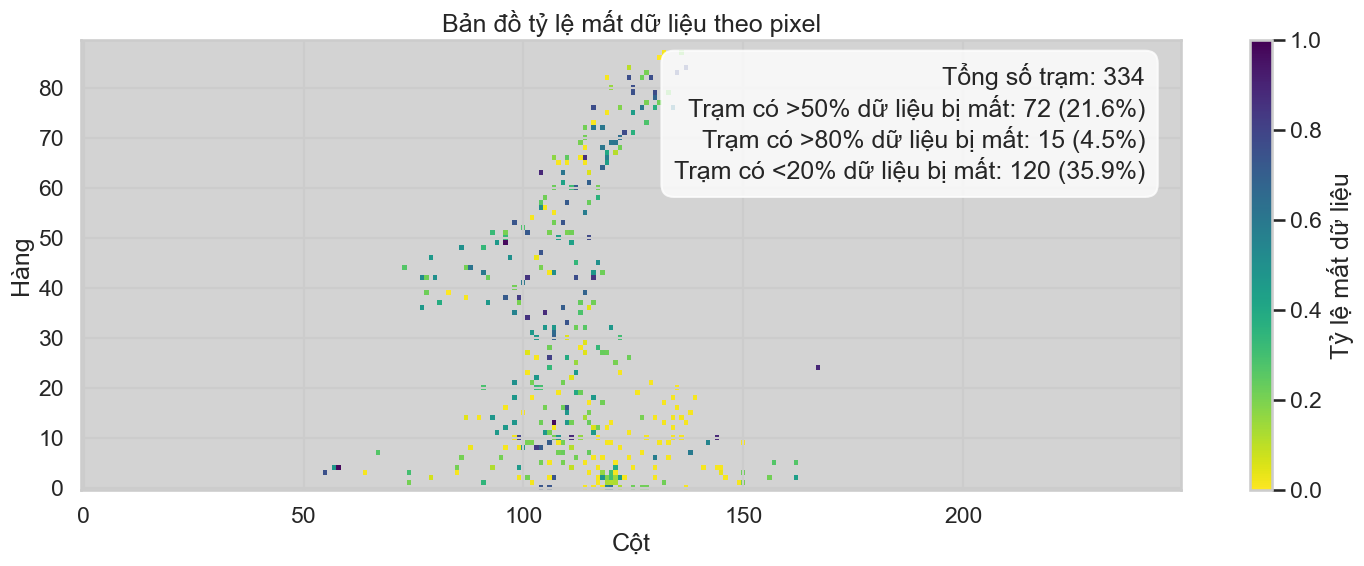

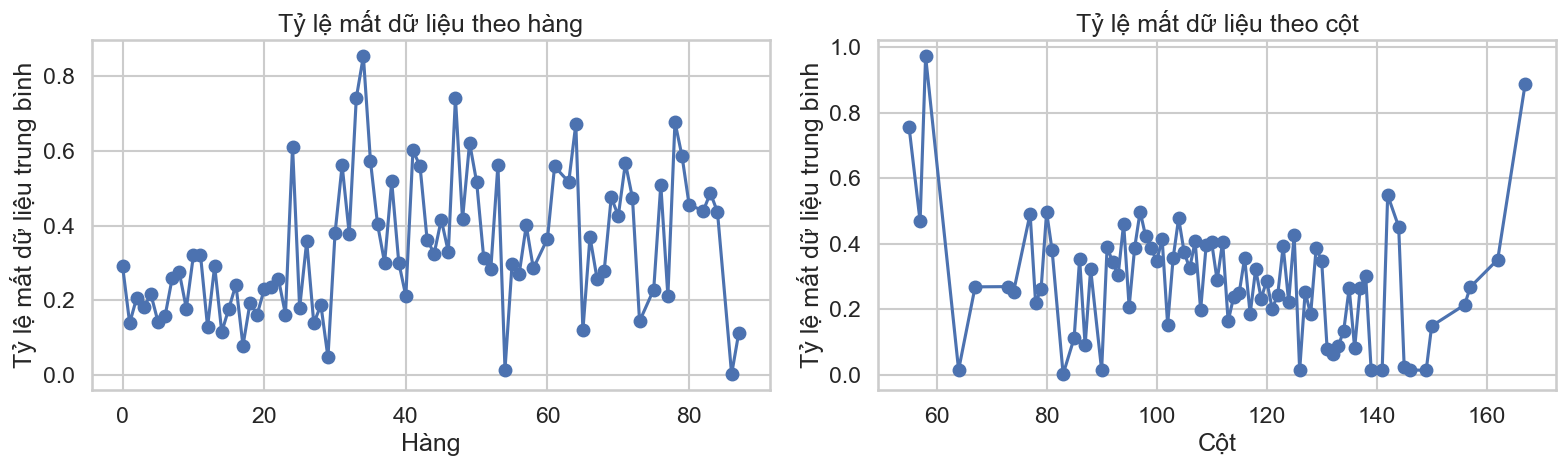

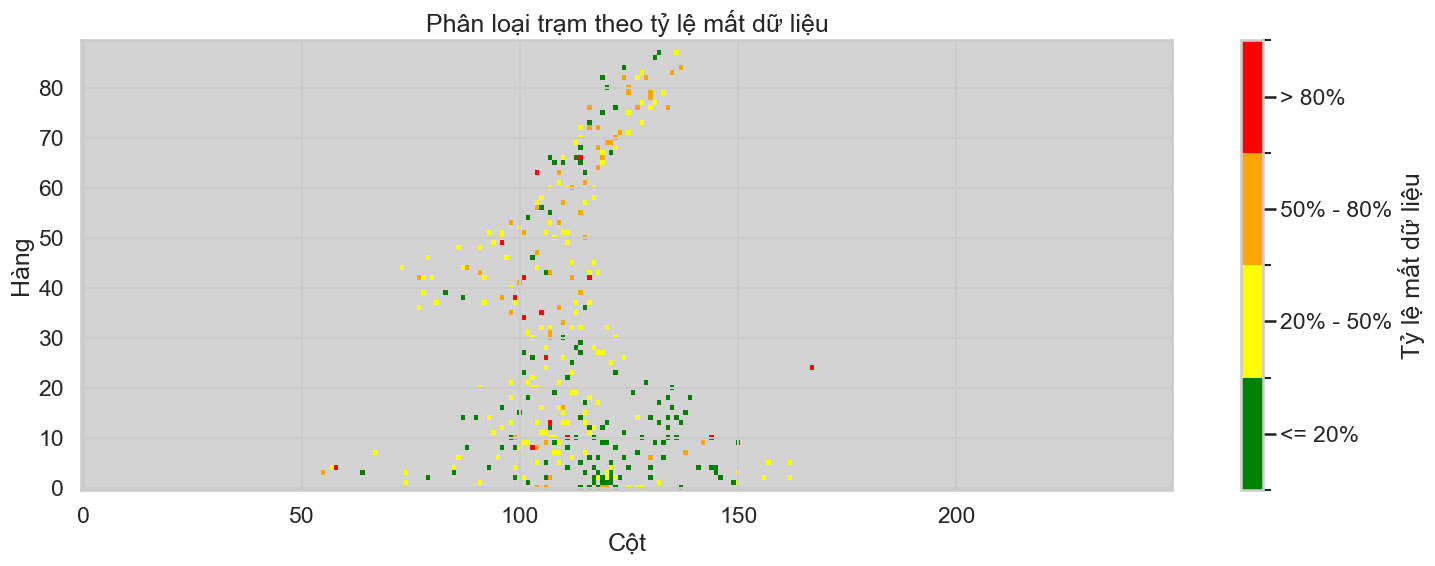

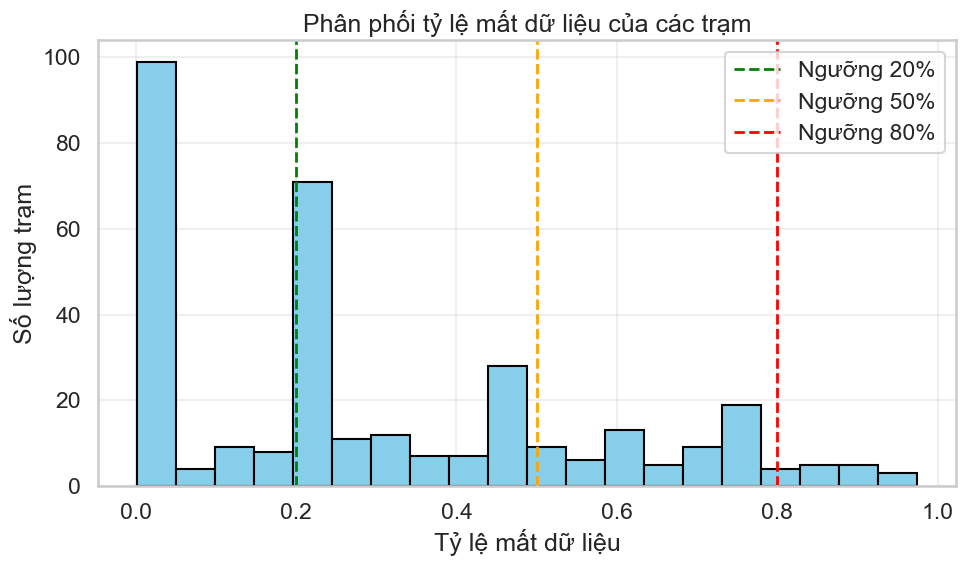

In [18]:
# Vẽ bản đồ tỷ lệ mất dữ liệu theo pixel

# 1. Tạo một mảng 2D để lưu trữ tỷ lệ mất dữ liệu của từng pixel
missing_ratio_map = np.zeros((90, 250))
missing_ratio_map.fill(np.nan)  # Đặt giá trị mặc định là NaN cho các pixel không có trạm

# 2. Điền tỷ lệ mất dữ liệu vào mảng 2D
for pixel_id, missing_ratio in missing_by_station.items():
    row, col = pixel_id.split('_')
    row, col = int(row), int(col)
    missing_ratio_map[row, col] = missing_ratio

# 3. Vẽ bản đồ tỷ lệ mất dữ liệu
plt.figure(figsize=(15, 6))
cmap = plt.cm.viridis_r  # viridis_r để hiển thị giá trị cao (nhiều mất dữ liệu) với màu sáng hơn
cmap.set_bad('lightgray')  # Màu cho các giá trị NaN (không có trạm)

img = plt.imshow(missing_ratio_map, cmap=cmap, vmin=0, vmax=1, aspect='auto', origin='lower')
cbar = plt.colorbar(img, label='Tỷ lệ mất dữ liệu')

plt.title('Bản đồ tỷ lệ mất dữ liệu theo pixel')
plt.xlabel('Cột')
plt.ylabel('Hàng')

# 4. Thêm các chi tiết phân tích
total_stations = len(missing_by_station)
high_missing = (missing_by_station > 0.5).sum()
very_high_missing = (missing_by_station > 0.8).sum()
low_missing = (missing_by_station < 0.2).sum()

# Đặt văn bản ở góc trên bên phải của đồ thị thay vì dưới cùng
plt.annotate(
    f"Tổng số trạm: {total_stations}\n" +
    f"Trạm có >50% dữ liệu bị mất: {high_missing} ({high_missing/total_stations:.1%})\n" +
    f"Trạm có >80% dữ liệu bị mất: {very_high_missing} ({very_high_missing/total_stations:.1%})\n" +
    f"Trạm có <20% dữ liệu bị mất: {low_missing} ({low_missing/total_stations:.1%})",
    xy=(0.98, 0.98), xycoords='axes fraction',
    xytext=(-10, -10), textcoords='offset points',
    ha='right', va='top',
    bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()

# 5. Phân tích phân phối không gian của tỷ lệ mất dữ liệu
# Tạo DataFrame chứa tọa độ và tỷ lệ mất dữ liệu
missing_coords = pd.DataFrame([{'pixel_id': pid, 
                                'row': int(pid.split('_')[0]), 
                                'col': int(pid.split('_')[1]),
                                'missing_ratio': ratio} 
                              for pid, ratio in missing_by_station.items()])

# Tính toán các thống kê theo hàng và cột
row_stats = missing_coords.groupby('row')['missing_ratio'].mean().reset_index()
col_stats = missing_coords.groupby('col')['missing_ratio'].mean().reset_index()

# Vẽ biểu đồ tỷ lệ mất dữ liệu theo hàng và cột
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Tỷ lệ mất dữ liệu theo hàng
axes[0].plot(row_stats['row'], row_stats['missing_ratio'], 'o-')
axes[0].set_xlabel('Hàng')
axes[0].set_ylabel('Tỷ lệ mất dữ liệu trung bình')
axes[0].set_title('Tỷ lệ mất dữ liệu theo hàng')
axes[0].grid(True)

# Tỷ lệ mất dữ liệu theo cột
axes[1].plot(col_stats['col'], col_stats['missing_ratio'], 'o-')
axes[1].set_xlabel('Cột')
axes[1].set_ylabel('Tỷ lệ mất dữ liệu trung bình')
axes[1].set_title('Tỷ lệ mất dữ liệu theo cột') 
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 6. Phân tích xem các trạm mất dữ liệu nhiều có tập trung theo vùng không
# Tạo bản đồ phân cụm tỷ lệ mất dữ liệu
plt.figure(figsize=(15, 6))

# Chia các trạm thành 4 nhóm dựa trên tỷ lệ mất dữ liệu
missing_categories = np.zeros((90, 250))
missing_categories.fill(np.nan)  # Đặt giá trị mặc định là NaN cho các pixel không có trạm

for pixel_id, missing_ratio in missing_by_station.items():
    row, col = pixel_id.split('_')
    row, col = int(row), int(col)
    
    if missing_ratio <= 0.2:
        category = 0  # Mất ít dữ liệu (<= 20%)
    elif missing_ratio <= 0.5:
        category = 1  # Mất dữ liệu vừa phải (20% - 50%)
    elif missing_ratio <= 0.8:
        category = 2  # Mất nhiều dữ liệu (50% - 80%)
    else:
        category = 3  # Mất rất nhiều dữ liệu (> 80%)
    
    missing_categories[row, col] = category

# Vẽ bản đồ phân loại
cmap = colors.ListedColormap(['green', 'yellow', 'orange', 'red'])
cmap.set_bad('lightgray')
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(missing_categories, cmap=cmap, norm=norm, aspect='auto', origin='lower')
cbar = plt.colorbar(img, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['<= 20%', '20% - 50%', '50% - 80%', '> 80%'])
cbar.set_label('Tỷ lệ mất dữ liệu')

plt.title('Phân loại trạm theo tỷ lệ mất dữ liệu')
plt.xlabel('Cột')
plt.ylabel('Hàng')

plt.tight_layout()
plt.show()

# 7. Vẽ biểu đồ phân phối tỷ lệ mất dữ liệu
plt.figure(figsize=(10, 6))
plt.hist(missing_by_station, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.2, color='green', linestyle='--', linewidth=2, label='Ngưỡng 20%')
plt.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Ngưỡng 50%')
plt.axvline(0.8, color='red', linestyle='--', linewidth=2, label='Ngưỡng 80%')

plt.title('Phân phối tỷ lệ mất dữ liệu của các trạm')
plt.xlabel('Tỷ lệ mất dữ liệu')
plt.ylabel('Số lượng trạm')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()